In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import bic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.api import qqplot
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from pandas.tseries.offsets import DateOffset

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("数据.xlsx")

# 将时间列转换为时间格式，并将其设置为索引
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.iloc[:, 0], inplace=True)

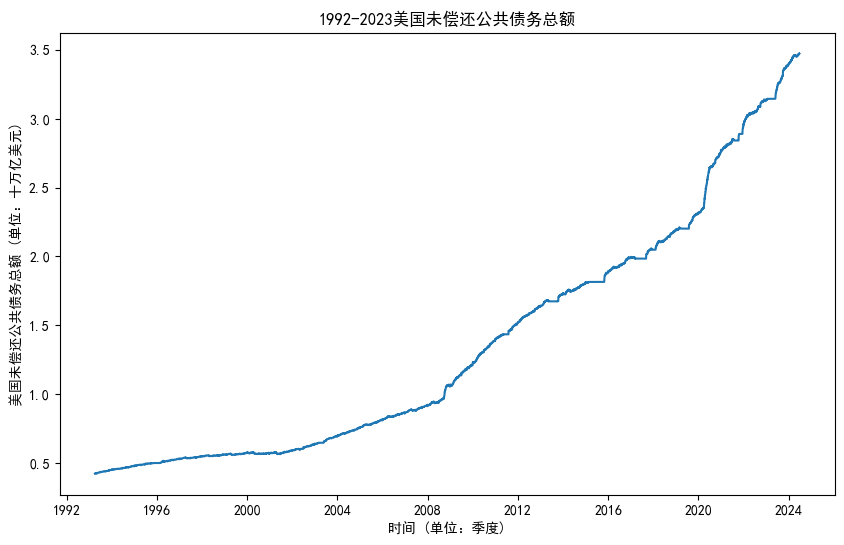

In [2]:
x = df.iloc[:, 0]
y = df.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x, y/1e13, label='数据变化')
plt.xlabel('时间 (单位：季度)')
plt.ylabel('美国未偿还公共债务总额 (单位：十万亿美元)')
plt.title('1992-2023美国未偿还公共债务总额')
plt.savefig('结果1-1/1992-2023美国未偿还公共债务总额.png')
plt.show()

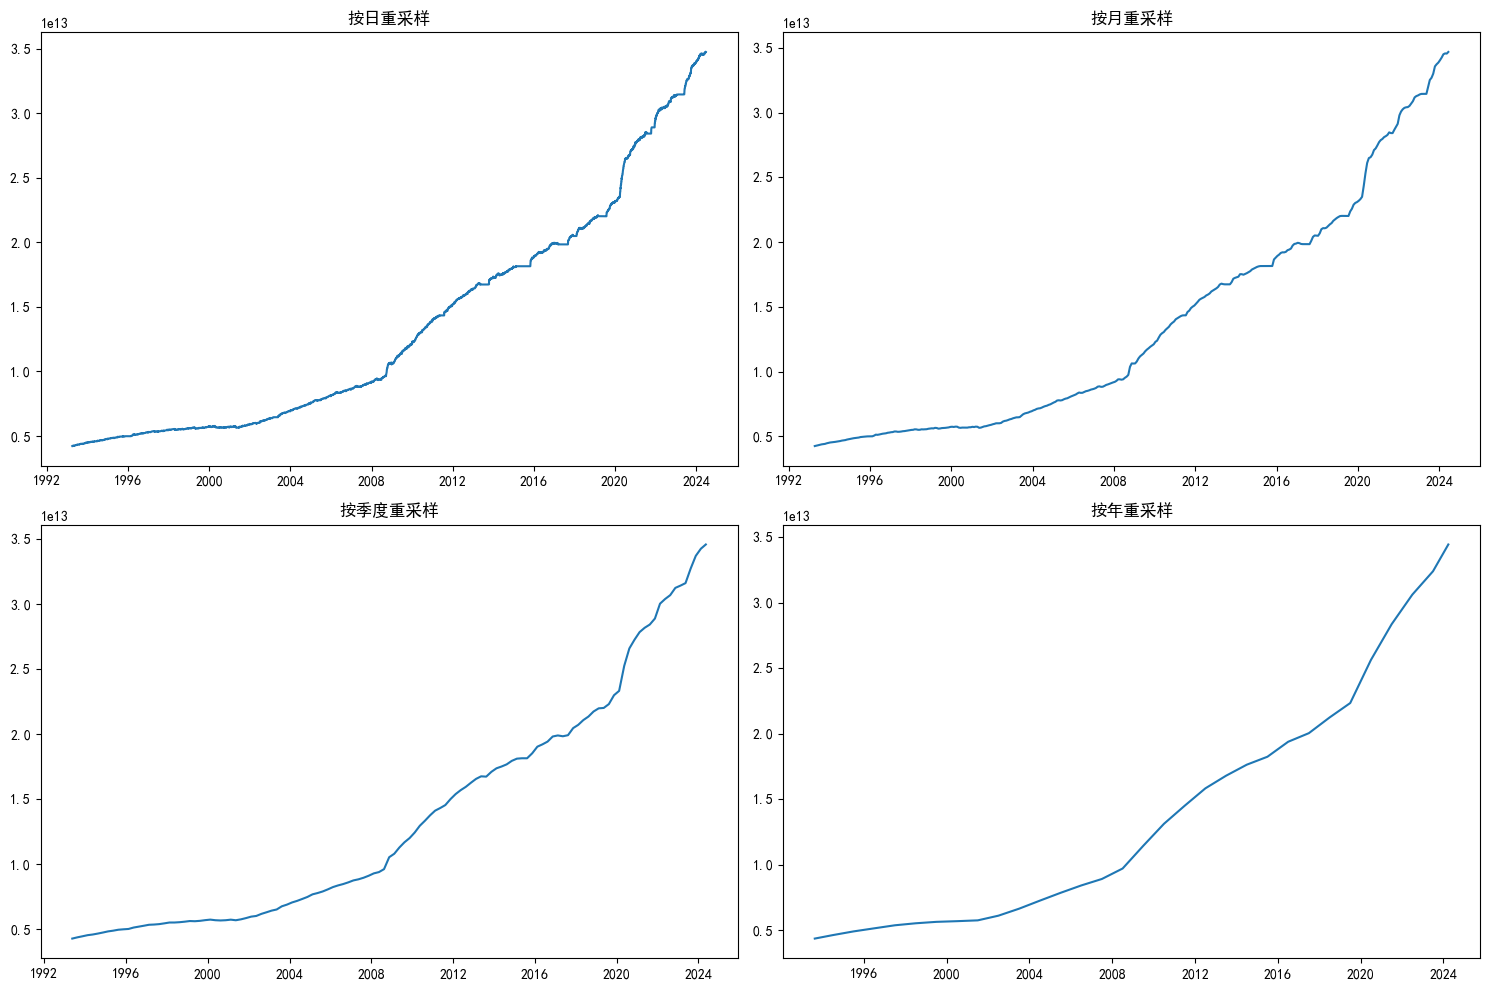

In [3]:
df_daily = df.resample('D').mean().interpolate()

df_mon = df_daily.resample('ME').mean()
df_quar = df_daily.resample('QE').mean()
df_year = df_daily.resample('YE').mean()
dfs = [df_daily, df_mon, df_quar, df_year]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.plot(dfs[i].iloc[:, 0], dfs[i].iloc[:, 1])
    ax.set_title(['按日重采样', '按月重采样', '按季度重采样', '按年重采样'][i])
plt.tight_layout()
plt.savefig('结果1-1/不同重采样.png')
plt.show()

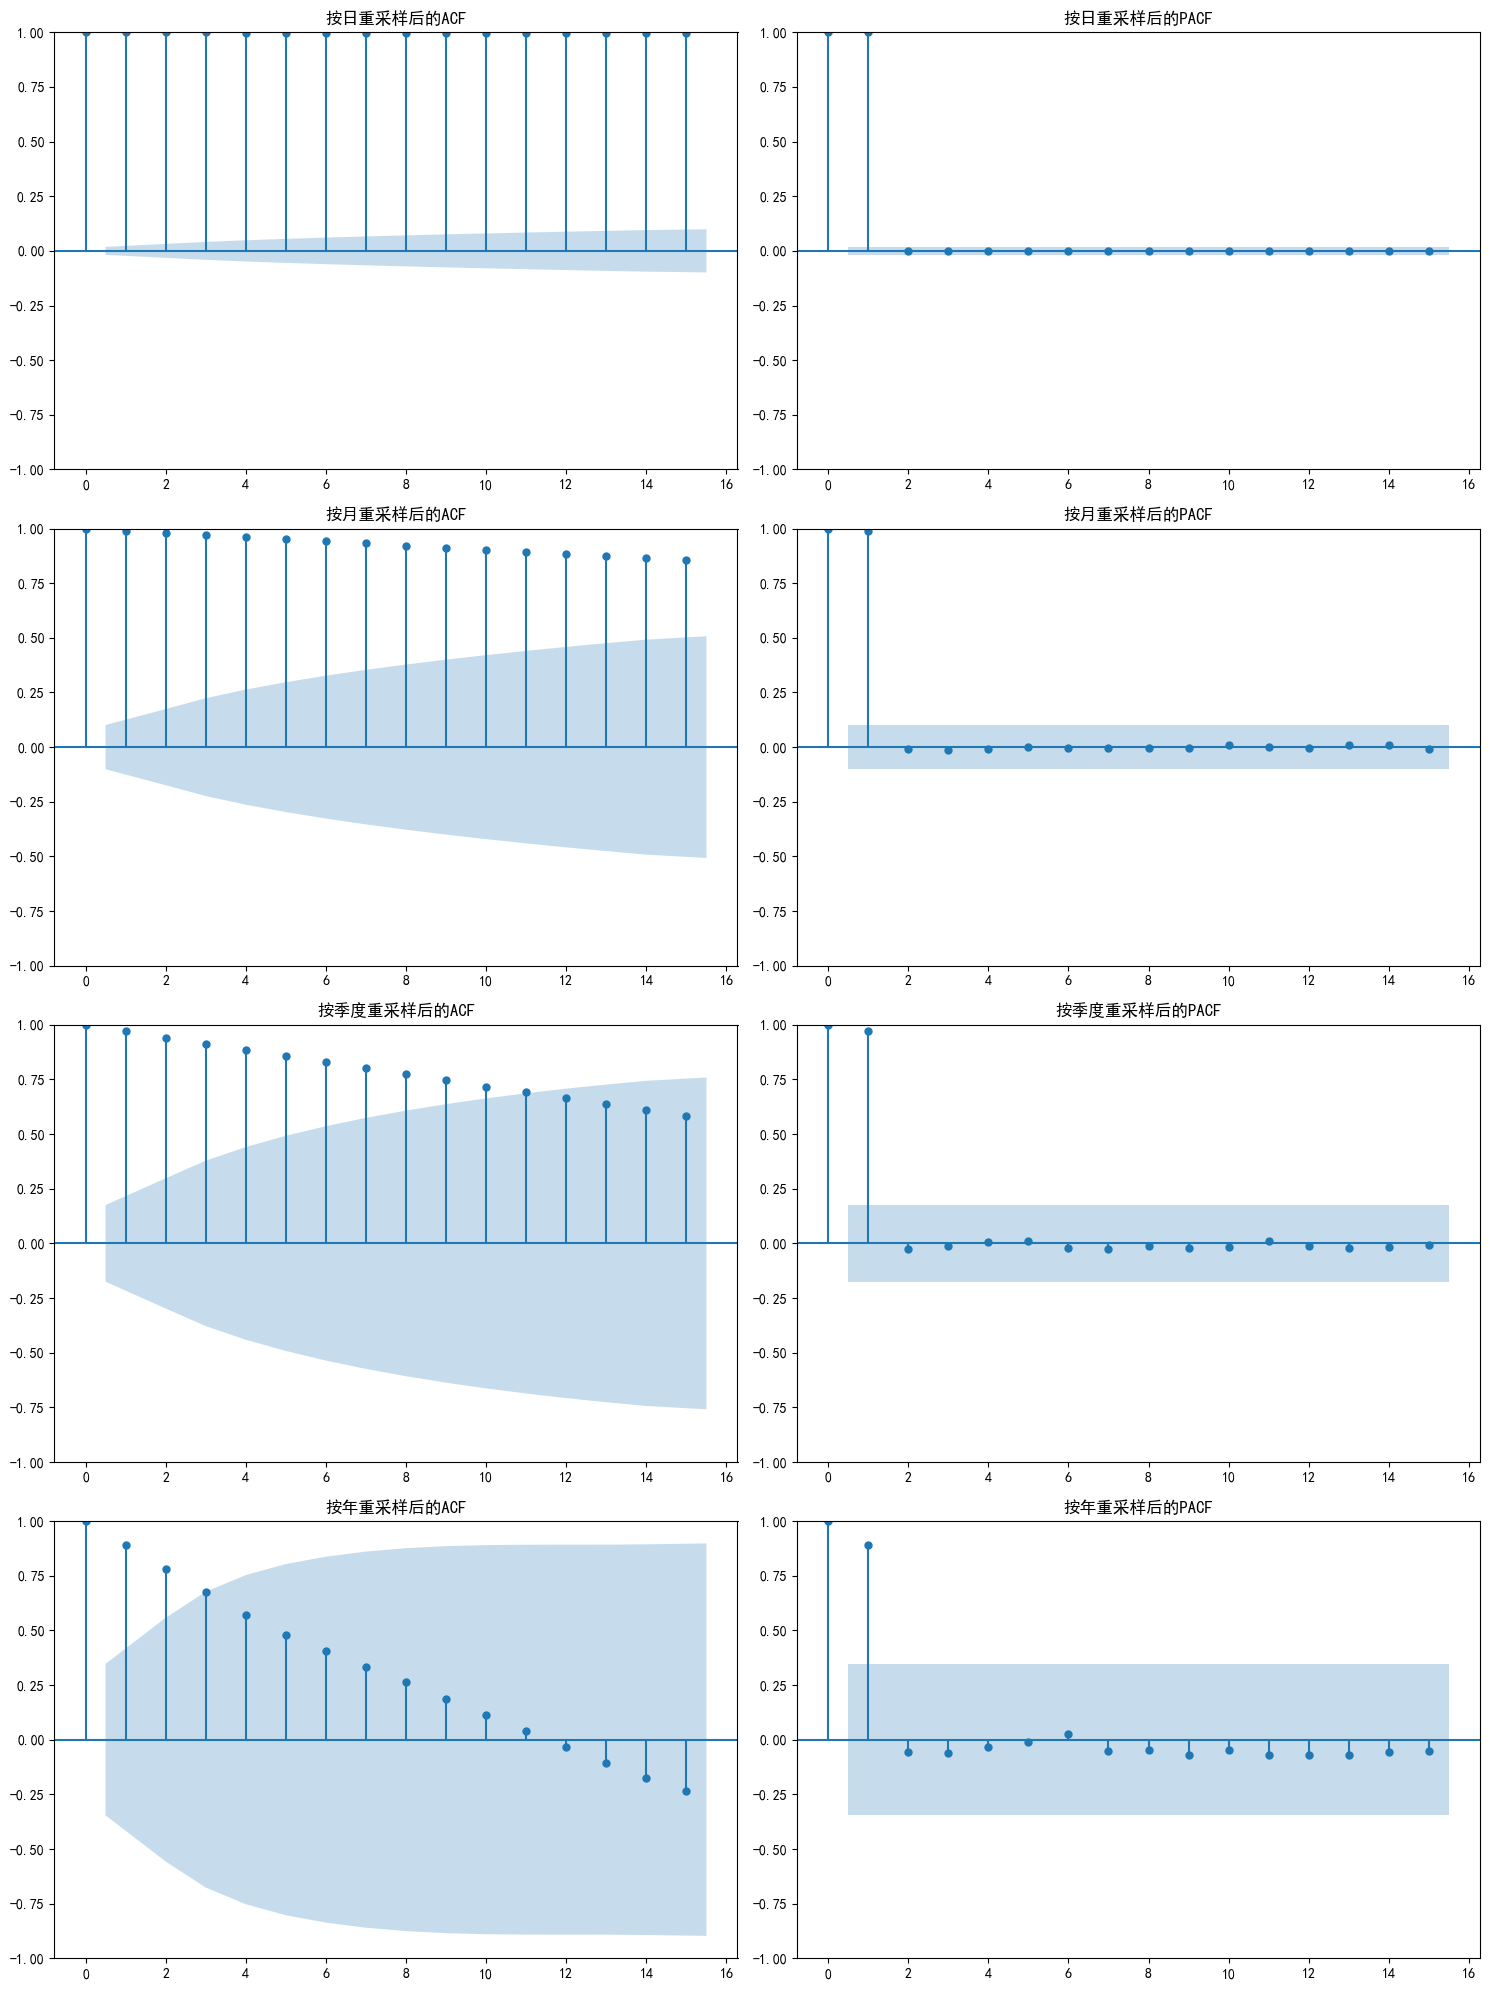

In [4]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plot_acf(dfs[i // 2].iloc[:, 1], ax=ax, lags=15)
    else:
        plot_pacf(dfs[i // 2].iloc[:, 1], ax=ax, lags=15)
    ax.set_title(['按日重采样后的', '按月重采样后的', '按季度重采样后的', '按年重采样后的'][i // 2] + ['ACF', 'PACF'][i % 2])
plt.tight_layout()
plt.savefig('结果1-1/不同重采样的ACF和PACF.png')
plt.show()

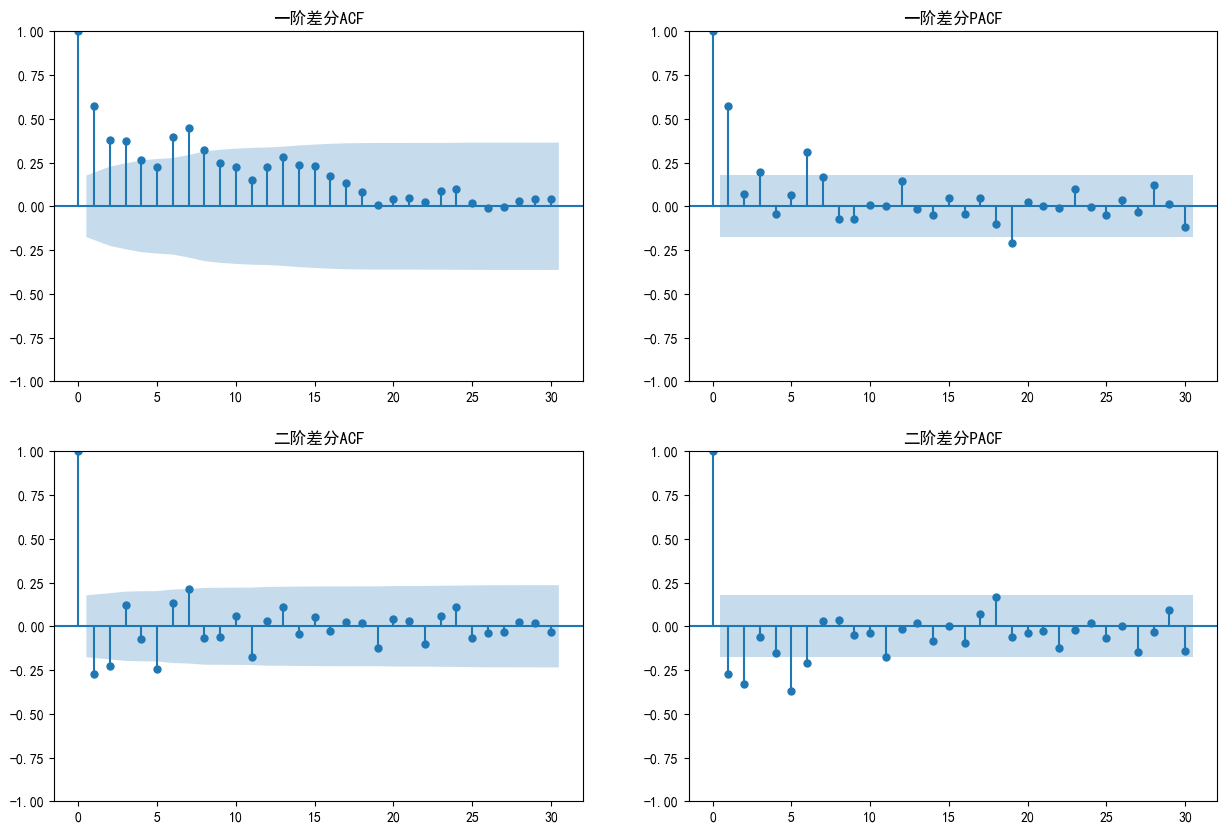

In [5]:
df_quar_d = df_quar.diff().dropna()
df_quar_dd = df_quar_d.diff().dropna()
dfds = [df_quar_d, df_quar_dd]
# 画出两种差分后的自相关和偏自相关图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plot_acf(dfds[i // 2].iloc[:, 1], ax=ax, lags=30)
    else:
        plot_pacf(dfds[i // 2].iloc[:, 1], ax=ax, lags=30)
    ax.set_title(['一阶差分', '二阶差分'][i // 2] + ['ACF', 'PACF'][i % 2])
plt.tight_layout
plt.savefig('结果1-1/一阶差分和二阶差分的ACF和PACF.png')
plt.show()

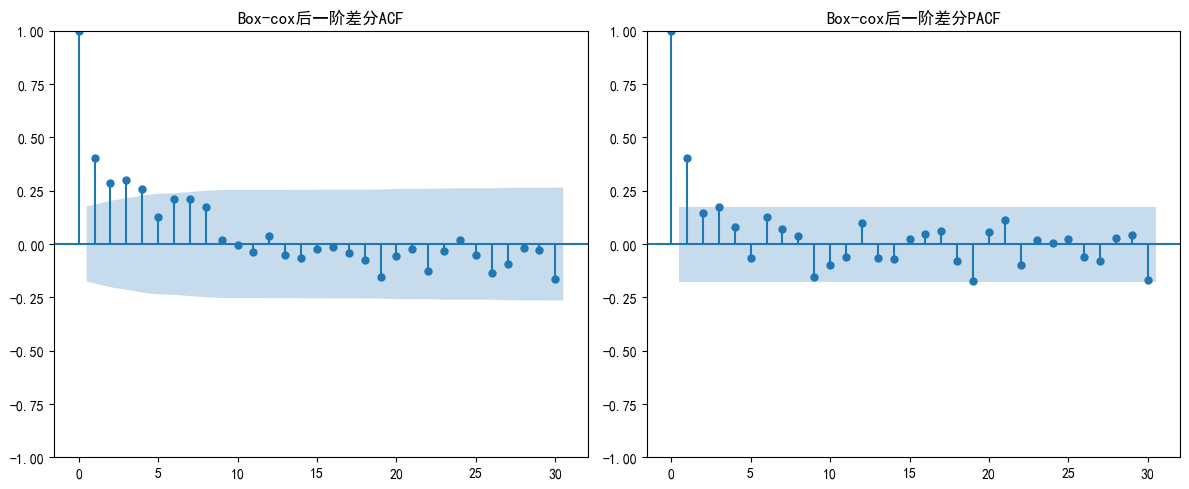

In [10]:
ts = df_quar.iloc[:, 1]
# Box-Cox变换
ts_boxcox, lambda_ = boxcox(ts)
# ts_boxcox = pd.Series(ts_boxcox, index=ts.index).diff().dropna()
bcdf_quar_d = pd.Series(ts_boxcox, index=ts.index).diff().dropna()
# bcdf_quar_dd = bcdf_quar_d.diff().dropna()
# bcdfds = [bcdf_quar_d, bcdf_quar_dd]
# 画出两种差分后的自相关和偏自相关图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        plot_acf(bcdf_quar_d, ax=ax, lags=30)
    else:
        plot_pacf(bcdf_quar_d, ax=ax, lags=30)
    ax.set_title(['Box-cox后一阶差分'][i // 2] + ['ACF', 'PACF'][i % 2])
plt.tight_layout()
plt.savefig('结果1-1/Box-cox后一阶差分的ACF和PACF.png')
plt.show()


c:\Users\Timothy\Desktop\python\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Timothy\Desktop\python\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


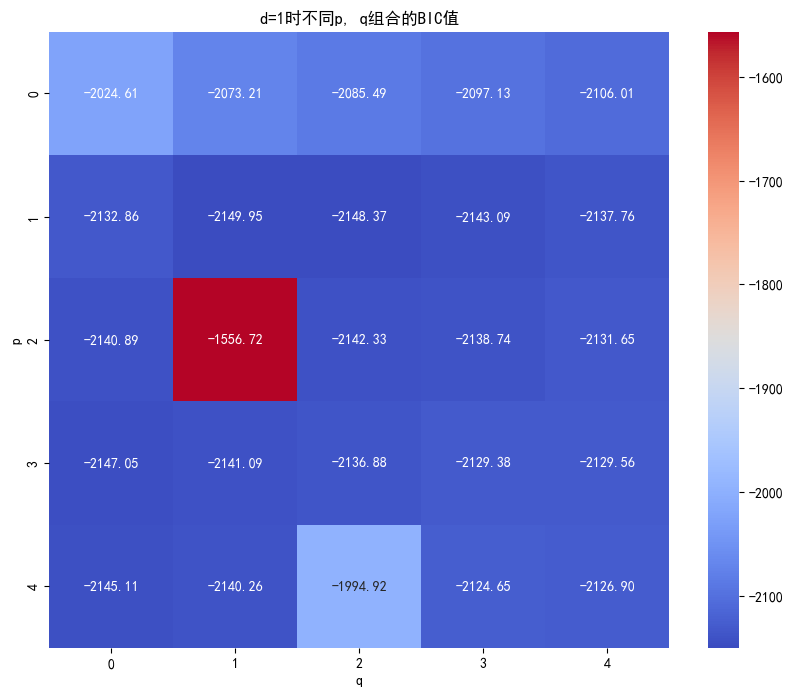

In [15]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
# 忽略ConvergenceWarning警告
warnings.simplefilter('ignore', ConvergenceWarning)
p_range = range(5)
q_range = range(5)
bic_values = pd.DataFrame(index=p_range, columns=q_range)

# 遍历所有的p, q组合
for p in p_range:
    for q in q_range:
        try:
            # 拟合ARIMA模型
            model = ARIMA(ts_boxcox, order=(p, 1, q))
            model_fit = model.fit()
            # 存储BIC值
            bic_values.loc[p, q] = model_fit.bic
        except:
            # 如果模型拟合失败，则存储一个大数
            bic_values.loc[p, q] = np.inf
# 将BIC值转换为float类型，以便于绘图
bic_values = bic_values.astype(float)
# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(bic_values, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('d=1时不同p, q组合的BIC值')
plt.xlabel('q')
plt.ylabel('p')
plt.savefig('结果1-1/d=1时不同pq组合的BIC值.png')
plt.show()

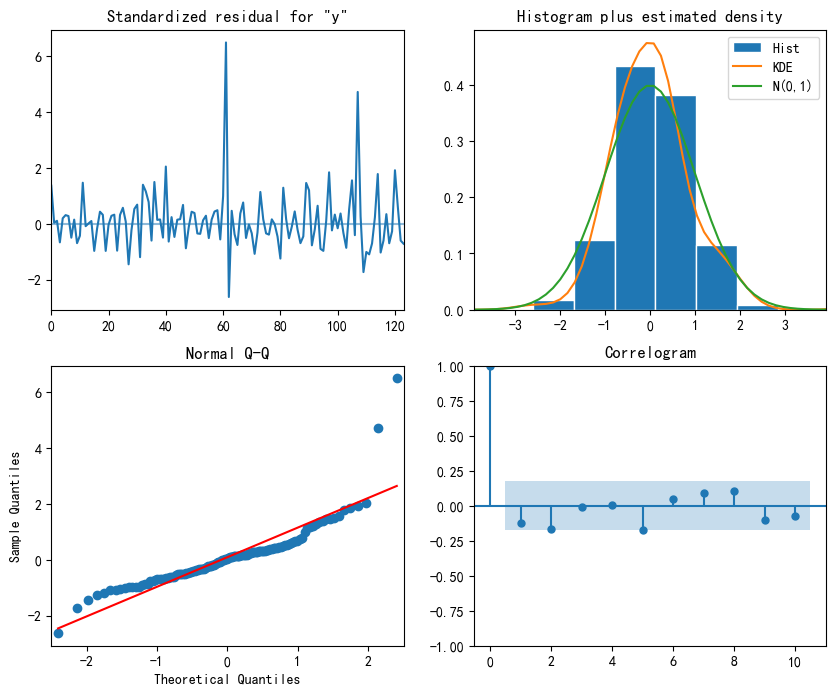

[3.50912844e+13 3.55594800e+13 3.60167843e+13 3.64632017e+13
 3.68987569e+13 3.73234931e+13 3.77374709e+13]
Record Date
2023-06-30    3.163621e+13
2023-09-30    3.274874e+13
2023-12-31    3.373535e+13
2024-03-31    3.428650e+13
2024-06-30    3.461221e+13
Freq: QE-DEC, Name: Total Public Debt Outstanding, dtype: float64
        Date               Forecast
0 2024-06-30  35091284360391.058594
1 2024-09-30  35559480043683.765625
2 2024-12-30  36016784310134.882812
3 2025-03-30  36463201719411.382812
4 2025-06-30  36898756874712.476562
5 2025-09-30  37323493067356.539062
6 2025-12-30  37737470946071.421875


In [16]:
# 1. 模型拟合
model = ARIMA(ts_boxcox, order=(1, 1, 1))
model_fit = model.fit()
# 2. 模型诊断
model_fit.plot_diagnostics(figsize=(10, 8))
plt.savefig('结果1-1/ARIMA模型诊断.png')
plt.show()
# 3. 预测
steps = 7
forecast = model_fit.forecast(steps=steps)
# 将预测结果转换回原始尺度
forecast_original_scale = inv_boxcox(forecast, lambda_)

# 获取最后一个时间点
last_date = ts.index[-1]
# 创建未来6个季度的时间点
future_dates = [last_date + DateOffset(months=x) for x in range(0, 3*steps, 3)]

forecast_matrix = forecast_original_scale.reshape(-1, 1)
dates_matrix = np.array(future_dates).reshape(-1, 1)
result_matrix = np.hstack((dates_matrix, forecast_matrix))
result_df = pd.DataFrame(result_matrix, columns=['Date', 'Forecast'])
print(forecast_original_scale)
print(ts[-5:])
print(result_df)

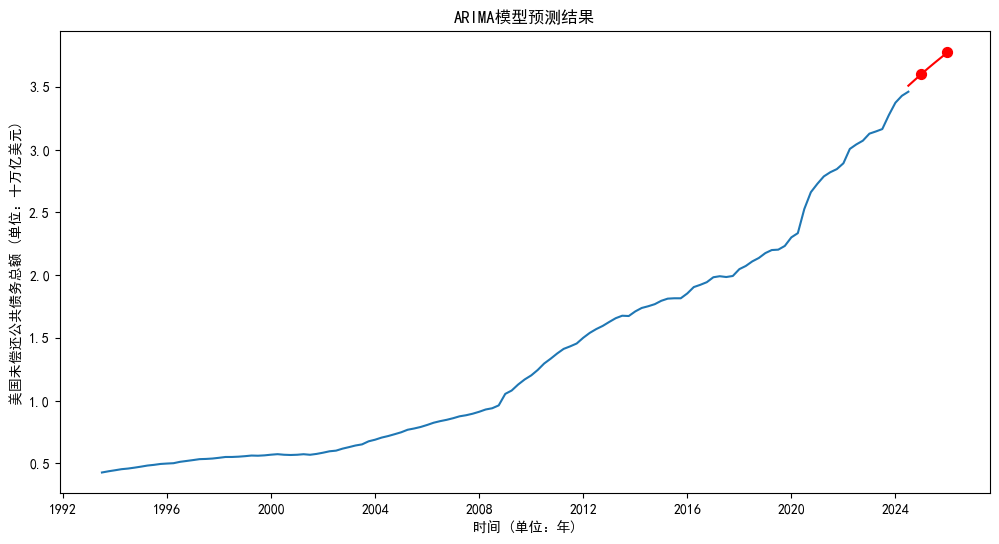

In [21]:
# 绘制原始数据
plt.figure(figsize=(12, 6))
plt.plot(ts/1e13, label='Original Data')
# 绘制预测结果
plt.plot(pd.to_datetime(result_df['Date']), result_df['Forecast']/1e13, label='Forecast', color='red')
# 特定日期
dates_to_highlight = ['2024-12-30', '2025-12-30']

# 在原始数据和预测结果中查找这些日期的值
for date in dates_to_highlight:
    # 转换日期字符串为pandas的日期时间格式
    date_pd = pd.to_datetime(date)
    # 检查这个日期是否在预测结果中
    if date_pd in pd.to_datetime(result_df['Date']).values:
        forecast_value = result_df.loc[pd.to_datetime(result_df['Date']) == date_pd, 'Forecast'].values[0]
        plt.scatter(date_pd, forecast_value/1e13, color='red', s=50)
# 显示图表
plt.title('ARIMA模型预测结果')
plt.xlabel('时间 (单位：年)')
plt.ylabel('美国未偿还公共债务总额 (单位：十万亿美元)')
plt.savefig('结果1-1/ARIMA模型预测结果.png')
plt.show()


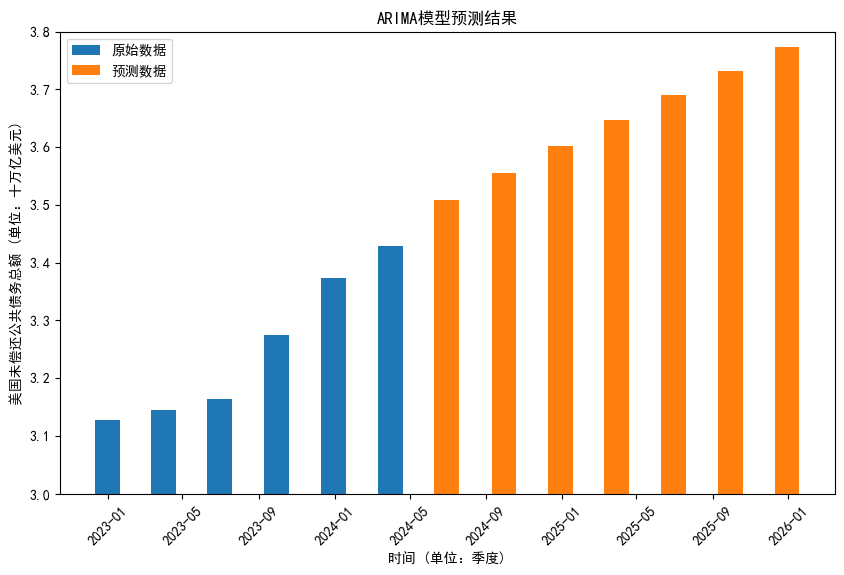

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(ts.index[-7:-1], ts[-7:-1]/1e13, label='原始数据', width=40)
plt.bar(pd.to_datetime(result_df['Date']), result_df['Forecast']/1e13, label='预测数据', width=40)
plt.xticks(rotation=45)
plt.xlabel('时间 (单位：季度)')
plt.ylabel('美国未偿还公共债务总额 (单位：十万亿美元)')
plt.ylim(3.0, 3.8)
plt.title('ARIMA模型预测结果')
plt.legend()
plt.savefig('结果1-1/ARIMA模型预测结果柱状图.png')
plt.show()